In [1]:
"""Startup"""
%matplotlib inline
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tkinter import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn import preprocessing
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


from sklearn.naive_bayes import MultinomialNB
import time


globalDataSet = pd.DataFrame(columns=['data', 'grade'])


pathToDataCollectorDatabase = 'D:\\PythonTestMid'

In [2]:
def searchFiles(path, fileformats):
    filesToDo = []
    for root, dirs, files in os.walk(path):
        for file in files:
            for fileformat in fileformats:
                if file.endswith(fileformat):
                    #code to generate a list of paths of files to generate logs for
                    filesToDo.append(os.path.join(root, file).removeprefix(path))
    return filesToDo

def searchFileName(path, fileName):
    filesToDo = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if file == fileName:
                #code to generate a list of paths of files to generate logs for
                filesToDo.append(os.path.join(root, file).removeprefix(path))
    return filesToDo

In [3]:

filesToIndex = searchFileName(pathToDataCollectorDatabase,"gitinfo.txt")
#Create a dataframe that contains the data of the gitinfo.txt files
import json
import warnings
warnings.filterwarnings('ignore')
i=0
#example of the gitinfo.txt file    {"id": 3452233, "name": "hjlebbink/asm-dude", "isFork": false, "commits": 939, "branches": 8, "defaultBranch": "master", "releases": 39, "contributors": 10, "license": "MIT License", "watchers": 762, "stargazers": 3906, "forks": 76, "size": 82262, "createdAt": "2016-02-19 03:43:23", "pushedAt": "2022-01-06 01:33:34", "updatedAt": "2022-01-08 08:02:49", "homepage": "", "mainLanguage": "Python", "totalIssues": 118, "openIssues": 32, "totalPullRequests": 13, "openPullRequests": 1, "lastCommit": "2021-12-07 08:47:07", "lastCommitSHA": "1e1e3dc2364e8ed549ba404868b6473ba435b25c", "hasWiki": true, "isArchived": false, "languages": {"Python": 4274689, "C#": 2554588, "C": 1311140, "C++": 644077, "Assembly": 164163, "Shell": 2764, "Go": 1779, "Batchfile": 410}, "labels": ["bug", "duplicate", "enhancement", "help wanted", "invalid", "question", "wontfix"]}
df = pd.DataFrame(columns=['id', 'name', 'isFork', 'commits', 'branches', 'defaultBranch', 'releases', 'contributors', 'license', 'watchers', 'stargazers', 'forks', 'size', 'createdAt', 'pushedAt', 'updatedAt', 'homepage', 'mainLanguage', 'totalIssues', 'openIssues', 'totalPullRequests', 'openPullRequests', 'lastCommit', 'lastCommitSHA', 'hasWiki', 'isArchived', 'languages', 'labels' , 'path'])
for file in filesToIndex:
    with open(pathToDataCollectorDatabase + file, 'r') as f:
        d = json.load(f)
    f.close()
    dftemp = pd.json_normalize(d)
    dftemp['path'] = file.removesuffix('gitinfo.txt')
    df = pd.concat([df, dftemp], ignore_index=True)
    i = i+1
df


,id,name,isFork,commits,branches,defaultBranch,releases,contributors,license,watchers,...,languages.Inno Setup,languages.sed,languages.AppleScript,languages.ASL,languages.Visual Basic .NET,languages.Jinja,languages.EJS,languages.Scala,languages.OCaml,languages.Smalltalk
0,3468763,albumidentify/albumidentify,False,758,6,master,0,6,None,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3475175,mattbasta/amo-validator,True,1141,5,master,0,19,BSD 3-Clause New or Revised License,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3471911,nadlabak/android_device_motorola_umts_sholes,False,377,5,gingerbread,0,6,None,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3452233,hjlebbink/asm-dude,False,939,8,master,39,10,MIT License,762,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3466103,sebnow/aur2,False,174,7,master,0,5,None,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,3505799,collective/tutorial.todoapp,False,210,5,master,1,13,None,126,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
120,3504693,marcua/tweeql,False,230,10,master,0,7,None,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
121,3468754,vereseproject/verese,False,205,5,master,0,14,BSD 3-Clause New or Revised License,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
122,3482497,dataignitelab/whaleshark_iiot,False,841,11,master,4,9,Apache License 2.0,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
#save the dataframe
df.to_csv(pathToDataCollectorDatabase + '\\gitinfo.csv', index=False)

In [6]:
#load the dataframe instead of getting it from files.
import json
import warnings
df = pd.read_csv(pathToDataCollectorDatabase + '\\gitinfo.csv')

In [4]:
# Print iterations progress
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
        printEnd    - Optional  : end character (e.g. "\r", "\r\n") (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end = printEnd)
    # Print New Line on Complete
    if iteration == total: 
        print()

In [5]:
#Grading V2
import numpy as np
import requests

fileformatToUse = ".txt"
useGITAPI = False


#commit comment keywords for code grade adjustment
positiveKeyWords = ['fix', 'resolve', 'resolve', 'resolved', 'resolves', 'resolving', 'close', 'closed', 'closes', 'closing', 'fixes', 'fixed', 'fixing', 'patch', 'patched', 'patching', 'update', 'updated', 'updating', 'upgrade', 'upgraded', 'upgrading', 'improve', 'improved', 'improving', 'improvement', 'improvements', 'improves', 'improving', 'enhance', 'enhanced', 'enhances', 'enhancing', 'enhancement', 'enhancements', 'improve', 'improved', 'improves', 'improving', 'improvement', 'improvements', 'improves', 'improving', 'improve', 'improved', 'improves', 'improving', 'improvement', 'improvements', 'improves', 'improving', 'improve', 'improved', 'improves', 'improving', 'improvement', 'improvements', 'improves', 'improving', 'improve', 'improved', 'improves', 'improving', 'improvement', 'improvements', 'improves', 'improving', 'improve', 'improved', 'improves', 'improving', 'improvement', 'improvements', 'improves', 'improving', 'improve', 'improved', 'improves', 'improving', 'improvement', 'improvements', 'improves', 'improving', 'improve', 'improved', 'improves', 'improving', 'improvement', 'improvements', 'improves', 'improving', 'improve', 'improved', 'improves', 'improving', 'improvement', 'improvements', 'improves', 'improving', 'improve', 'improved', 'improves', 'improving', 'improvement', 'improvements', 'improves', 'improving', 'improve', 'improved', 'improves', 'improving']
positiveKeyWordsBigImpact = ['Signed-off', 'Merge', 'Merged']
positiveKeyWordsValue = 1
positiveKeyWordsBigImpactValue = 5
negitiveKeyWords = ['todo','tofix','bugged','fix me']
negitiveKeyWordsValue = -1

prevCommitScoreAdjustmentNegitiveKeyWords = ['revert','reverted','reverting','reverts']
prevCommitScoreAdjustmentNegitiveKeyWordsValue = -10



import numpy as np
filesToIndex = df['path'].tolist()
#Create an array of strings of folders which contain a 0.txt file
foldersWithCommits = []
for file in filesToIndex:
    for filelvl2 in searchFileName(pathToDataCollectorDatabase+file, "0.txt"):
        #print(pathToDataCollectorDatabase+file+filelvl2.removesuffix('0.txt'))
        if (searchFiles(pathToDataCollectorDatabase+file+filelvl2.removesuffix('0.txt'), fileformatToUse) != []):
            foldersWithCommits.append(file+filelvl2.removesuffix('0.txt'))
            





#get the total number of commits for each folder
totalCommits = []
for folder in foldersWithCommits:
    totalCommits.append(len(searchFiles(pathToDataCollectorDatabase+folder, ['.txt'])))

dataSet1 = pd.DataFrame(columns=['data', 'grade'])
repositoryName = ''
prevRepositoryName = ''
repoInfo = ''
#make multitheaded

index = 0
for i in foldersWithCommits:
    printProgressBar(index, len(foldersWithCommits), prefix = 'Progress:', suffix = 'Complete', length = 50)
    index = index + 1
    authorsEmail = []
    authors = []
    repositoryName = i.split('\\')[1]

    if (repositoryName != prevRepositoryName):
        data = open(pathToDataCollectorDatabase+'\\' + repositoryName+'\\gitinfo.txt', 'r', encoding="utf8")
        repoInfo = json.loads(data.read())
        data.close()
    repoBaseScore = 0
    #subtract the dates from creation date and last updated date to get an age score
    import datetime
    #'%Y-%m-%d T%H:%M:%SZ'
    repoAge = (datetime.datetime.strptime(repoInfo['updatedAt'], '%Y-%m-%d %H:%M:%S') - datetime.datetime.strptime(repoInfo['createdAt'], '%Y-%m-%d %H:%M:%S'))
    repoAge = repoAge.days
    #The older the repo the higher the score
    ageScore = 200 - (repoAge/365)*100
    #add a score based on the number of contributors
    contributorRepoScore = repoInfo['contributors']*5
    #add a score based on the number of stars
    starScore = repoInfo['stargazers'] * 10
    #add a score based on the number of forks
    forkScore = repoInfo['forks'] * 10
    #add a score based on the number of watchers
    watchScore = repoInfo['watchers'] * 10
    #add a score based on the number of issues
    repoBaseScore = repoBaseScore + (repoInfo['totalIssues'] * 10)
    totIssues = repoInfo['totalIssues']
    opIssues = repoInfo['openIssues']
    if (opIssues != 0):
        issuesScore = 90 - (totIssues/opIssues)*100
    else:
        issuesScore = -1


    #get the top 2 scores
    top2Scores = sorted([ageScore, contributorRepoScore, starScore, forkScore, watchScore, issuesScore], reverse=True)[:2]
    #add the top 2 scores together
    repoBaseScore = repoBaseScore + top2Scores[0] + top2Scores[1]
    repoBaseScore = repoBaseScore/50
    if (issuesScore == -1):
        repoBaseScore = repoBaseScore -15



    
    numberOfCommits = len(searchFiles(pathToDataCollectorDatabase+i, ['.txt']))

    #prevContributors = []      Maybe for future use
    #prevContributorsAmount = []

    for j in range(len(searchFiles(pathToDataCollectorDatabase+i, ['.txt']))):

        authorsEmailCache = authorsEmail.copy()
        skip = False
        
        try :
            data = open(pathToDataCollectorDatabase+i+str(j)+fileformatToUse, 'r', encoding="utf8")
            commitdata = data.read()
            data.close()
            data1 = open(pathToDataCollectorDatabase+i+str(j)+'.json', 'r', encoding="utf8")
            commitinfo = data1.read()
            data1.close()
        except:
            #print("Error opening file: "+pathToDataCollectorDatabase+i+str(j)+fileformatToUse)
            commitdata = ''
            commitinfo = ''
            continue

        #get the number of contributors
        #error checking
        try:
            contributors = commitinfo.split('author\':')[1]
            contributors = contributors.split('\'date\':')[0]
            contributorscount = contributors.count("<")
        except:
            break
            print("error file = " + i+str(j)+".json")

        if (commitdata == ''):
            break
        contributorScore = contributorscount -1

        #find KeyWords in the commit message
        commitmessage = commitinfo.split('\'summary\':')[1]
        commitmessage = commitmessage.replace(', \'description\':', ' ')

        keyWordAdjustment = 0
        prevCommitAdjustment = 0
        #check the commit message for the words in positiveKeyWords
        for word in positiveKeyWords:
            if (commitmessage.find(word) != -1):
                keyWordAdjustment = keyWordAdjustment + positiveKeyWordsValue
        
        #check the commit message for the words in positiveKeyWordsBigImpact
        for word in positiveKeyWordsBigImpact:
            if (commitmessage.find(word) != -1):
                keyWordAdjustment = keyWordAdjustment + positiveKeyWordsBigImpactValue

        #check the commit message for the words in negitiveKeyWords
        for word in negitiveKeyWords:
            if (commitmessage.find(word) != -1):
                keyWordAdjustment = keyWordAdjustment + negitiveKeyWordsValue

        #check the commit message for the words in prevCommitScoreAdjustmentNegitiveKeyWords
        for word in prevCommitScoreAdjustmentNegitiveKeyWords:
            if (commitmessage.find(word) != -1):
                prevCommitAdjustment = prevCommitAdjustment + prevCommitScoreAdjustmentNegitiveKeyWordsValue
        """Impliment this later"""
        #if (prevCommitAdjustment != 0):
            #dataSet1['grade'].last = dataSet1['grade'].last + prevCommitAdjustment

        topBaseScoreAddition = 50
        topContributorScoreAddition = 15
        topKeyWordScoreAddition = 15
        topCommitNumbScoreAddition = 20

        if (keyWordAdjustment > 5):
            KeyWordAdjustment = 5
        if (keyWordAdjustment < -5):
            KeyWordAdjustment = -5

        if (contributorscount > 3):
            contributorscount = 3

        finalKeywordScore = (keyWordAdjustment/5)*topKeyWordScoreAddition
        finalContributorScore = ((contributorScore/3)*topContributorScoreAddition)
        finalCommitScore = (topCommitNumbScoreAddition * (j / numberOfCommits))

        if(repoBaseScore > topBaseScoreAddition):
            repoBaseScore = topBaseScoreAddition


        commitGrade = np.clip(repoBaseScore + finalKeywordScore + finalContributorScore + finalCommitScore, 0,100)
        """if (commitGrade == 55):
            print(repoBaseScore)
            print(finalKeywordScore)
            print(finalContributorScore)
            print(finalCommitScore)"""
        dataSet1temp = pd.DataFrame({'data': [commitdata], 'grade': [commitGrade]})
        dataSet1 = pd.concat([dataSet1, dataSet1temp], ignore_index=True)

        

        #calculate Grade
        #create a minimum grade based off of stats from the github repo

        #get the authors info if using the GITHUB API. Maybe make into a seperate application that can then be used to generate a json file used here due to the rate limit of the API
        if (useGITAPI == True):
            authorsArray = contributors.split('>')
            for author in authorsArray:
                if (author.find('<') != -1):
                    authorsEmail.append(author[author.find('<')+1:])
            #use https://api.github.com/search/users?q= to get a username from an email address
            for author in authorsEmail:
                print(authorsEmailCache)
                if (author.find('@') != -1 and not (author in authorsEmailCache)):
                    print (author + 'test')
                    gitRequest = requests.get('https://api.github.com/search/users?q='+author).json()
                    if (gitRequest['total_count'] > 0):
                        authors.append(gitRequest['items'][0]['login'])
                        print("shouldn't show up")

                    #print (requests.get('https://api.github.com/search/users?q='+author).json()['items'][0]['login'])

    

dataSet1['grade'].value_counts()


50.000000    2783
60.000000     942
65.000000     848
56.666667     510
63.333333     506
             ... 
52.996552       1
50.168966       1
50.341379       1
53.513793       1
31.261538       1
Name: grade, Length: 15390, dtype: int64

In [11]:
#save the grading databse for testing purposes
dataSet1.to_csv(pathToDataCollectorDatabase + '\\dataSet1Grade.csv', index=False)

In [19]:
#load the grading databse for testing purposes
dataSet1 = pd.read_csv(pathToDataCollectorDatabase + '\\dataSet1Grade.csv')

<AxesSubplot: title={'center': 'Grade Distribution'}>

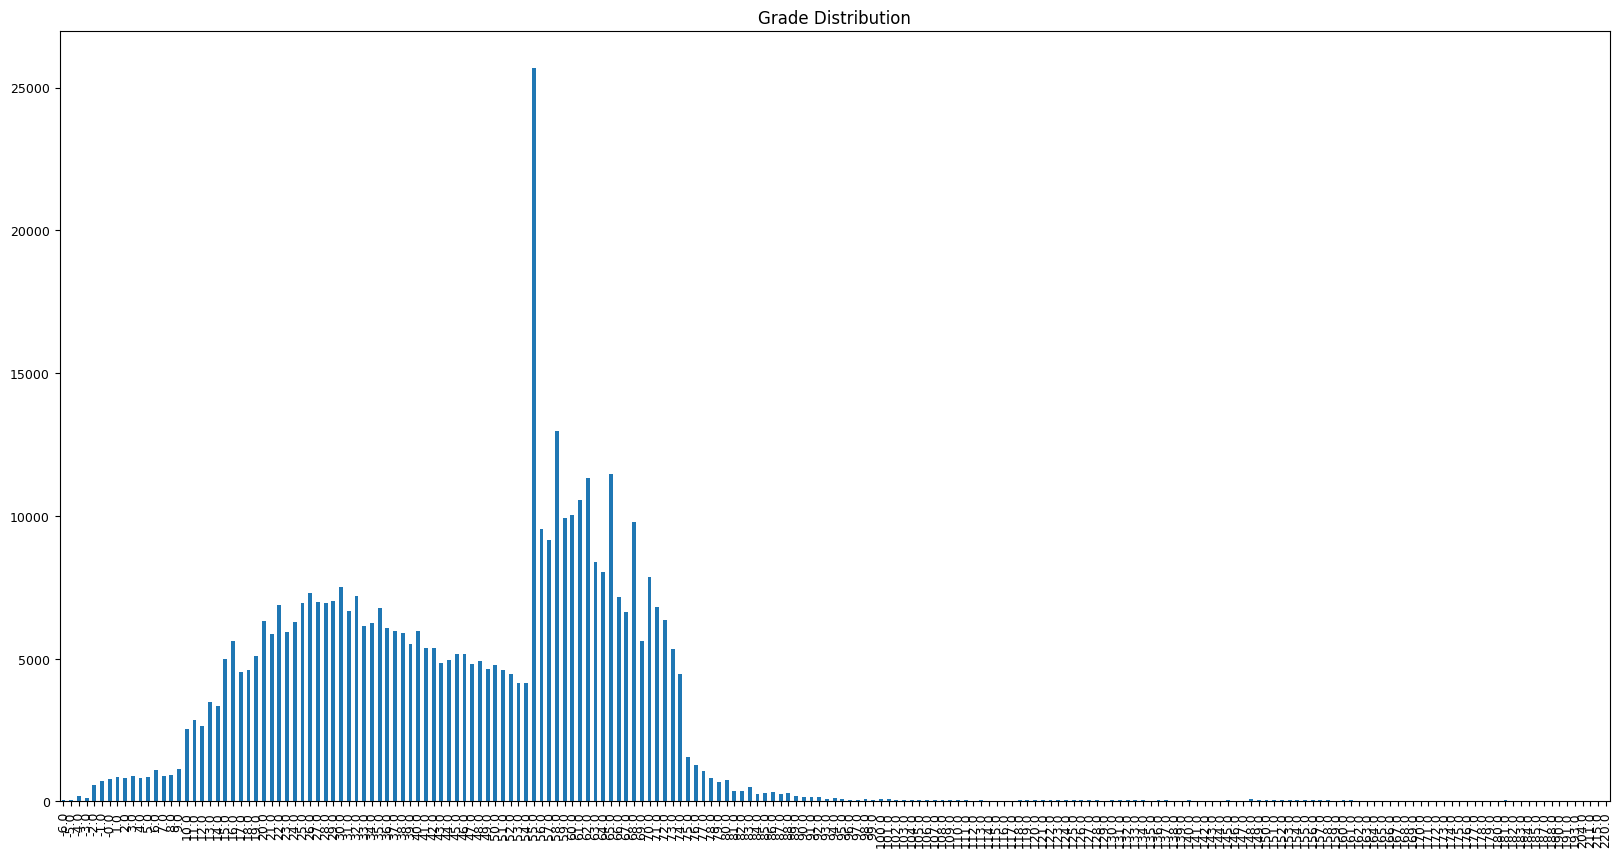

In [9]:
round(dataSet1['grade']).value_counts().sort_index().plot(kind='bar', title='Grade Distribution', figsize=(20,10), fontsize=9)

In [10]:
import sys
import re
print("Memory used by dataSet1: " + str(sys.getsizeof(dataSet1)))
memUsage = sys.getsizeof(dataSet1)
for j in range(len(dataSet1)):
    printProgressBar(j, len(dataSet1), prefix = 'Progress:', suffix = 'Complete', length = 50)
    #use regex to replace all new lines only with tabs to newlines without tabs eventually
    dataSet1['data'][j] = dataSet1['data'][j].replace('    ', '\t')
    dataSet1['data'][j] = dataSet1['data'][j].replace("\"\"\"" , "\"")
    dataSet1['data'][j] = dataSet1['data'][j].replace("\'\'\'" , "\"")
    dataSet1['data'][j] = dataSet1['data'][j].replace("\\'" , "")
    dataSet1['data'][j] = dataSet1['data'][j].replace('\\"' , "")
    dataSet1['data'][j] = re.sub("('|\")[\x1f-\x7e]{1,}?('|\")", " \"sGH\"", dataSet1['data'][j])
    dataSet1['data'][j] = re.sub("#.*", "", dataSet1['data'][j])
print("Memory used by dataSet1: " + str(sys.getsizeof(dataSet1)))
print("Memory Delta: " + str(sys.getsizeof(dataSet1) - memUsage))

def stringProcessing(string):
    string = string.replace('    ', '\t')
    string = string.replace("\"\"\"" , "\"")
    string = string.replace("\'\'\'" , "\"")
    string = string.replace("\\'" , "")
    string = string.replace('\\"' , "")
    string = re.sub("('|\")[\x1f-\x7e]{1,}?('|\")", " \"sGH\"", string)
    string = re.sub("#.*", "", string)
    return string


Memory used by dataSet1: 4494188365


C:\Users\Mcall\AppData\Local\Temp\ipykernel_12508\2058289997.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataSet1['data'][j] = dataSet1['data'][j].replace('    ', '\t')
C:\Users\Mcall\AppData\Local\Temp\ipykernel_12508\2058289997.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataSet1['data'][j] = dataSet1['data'][j].replace("\"\"\"" , "\"")
C:\Users\Mcall\AppData\Local\Temp\ipykernel_12508\2058289997.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

Memory used by dataSet1: 2804770439█████████████████████████-| 100.0% Complete
Memory Delta: -1689417926


In [ ]:
print(dataSet1.memory_usage(deep=True).sum()/1024/1024)
dataSet1

In [12]:
"Feature Creation using keras tokenizer"
"For data that only has a data column and a target column in a range from 0-100 respectively using a pandas dataframe"
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
import re


#File Size limits due to memory constraints

maxWords = 1000
maxLen = 9000

tokenizer = Tokenizer(filters='' , split=' ', lower=True, num_words=maxWords)
to_pad = ['\n', '\t', '\r', '(', ')', '[', ']', '{', '}', '<', '>', '!', '?', ',', '.', ':', ';', '`', '~', '@', '#', '$', '%', '^', '&', '*', '=', '+', '/', '\\', '|']

def stringPadding(dataSet):
    #tokenize dataSet
    #dataSet = padSymbols(dataSet)
    
    #get rid of excess \n
    #pad to_pad segments with spaces in dataSet
    if (type(dataSet) == str):
        for i in range(len(to_pad)):
            dataSet = dataSet.replace(to_pad[i], ' ' + to_pad[i] + ' ')
        return dataSet

for i in to_pad: 
    printProgressBar(to_pad.index(i), len(to_pad) - 1, prefix = 'Progress Padding Symbols:', suffix = 'Complete', length = 50)
    for j in range(len(dataSet1)):
        dataSet1['data'][j] = dataSet1['data'][j].replace(i, ' '+i+' ') 
tokenizer.fit_on_texts(dataSet1[dataSet1.columns[0]]) 
#X = tokenizer.texts_to_sequences(dataSet[dataSet.columns[0]])
#Do this line by line to save memory
dataSet1['data'] = tokenizer.texts_to_sequences(dataSet1['data'])
#Check the length of the longest sequence
dataLength = []

for i in range(len(dataSet1[dataSet1.columns[0]])):
    dataLength.append(len(i))
print("Longest Sequence: ", max(dataLength))
#get statistics on the length of the sequences
print("Mean Sequence Length: ", np.mean(dataLength))
print("Median Sequence Length: ", np.median(dataLength))
print("Standard Deviation of Sequence Length: ", np.std(dataLength))

tempMaxLength = np.median(dataLength) + 2 * np.std(dataLength)
print ("Temp Max Length: ", tempMaxLength)
"""
if tempMaxLength < maxLen:
    tempMaxLength = maxLen
    print("Max Length: ", tempMaxLength)
"""

#X = pad_sequences(X, maxlen=maxLen)
dataSet1[dataSet1.columns[0]] = pad_sequences(dataSet1[dataSet1.columns[0]], maxlen=tempMaxLength)

C:\Users\Mcall\AppData\Local\Temp\ipykernel_12508\2832641689.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataSet1['data'][j] = dataSet1['data'][j].replace(i, ' '+i+' ')


Progress Padding Symbols: |██████████████████████████████████████████████████| 100.0% Complete


C:\Users\Mcall\AppData\Local\Temp\ipykernel_12508\2832641689.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataSet1['data'][i] = tokenizer.texts_to_sequences(dataSet1['data'][i])


KeyboardInterrupt: 

In [18]:


print(dataSet1['grade'][0])

31.2


In [ ]:
#get the ammounts of tokens in the data set
from tokenize import TokenInfo




#print(tokenizer.word_index)

#print(tokenizer.word_counts)
"""
print(tokenizer.word_docs)
print(tokenizer.word_index)
print(tokenizer.document_count)
print(tokenizer.num_words)
print(tokenizer.index_docs)
print(tokenizer.index_word)
print(tokenizer.word_counts)
print(tokenizer.word_docs)
print(tokenizer.word_index)
print(tokenizer.document_count)
print(tokenizer.num_words)
print(tokenizer.index_docs)
print(tokenizer.index_word)
"""

print(dataSet1.memory_usage(deep=True).sum()/1024/1024)
#print a short version of X[0]
print(dataSet1[dataSet1.columns[0]][0])
#print data converted to text to see if it is correct
    
print(tokenizer.sequences_to_texts(dataSet1[dataSet1.columns[0]][0]))
print(dataSet1[dataSet1.columns[0]][1])


In [ ]:
from tokenize import TokenInfo
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import ConvLSTM2D
from keras.layers import TimeDistributed
from keras.layers import Conv2D

model = Sequential()

#delete the data row of dataSet1
dataSet1 = dataSet1.drop(dataSet1.index[0])

#get the number of unique words in the dataset
model.add(Embedding(maxWords+1, 2000, input_length=X.shape[1]))
#model.add(Conv1D(1024, 20, activation='relu'))
model.add(Conv1D(256, 4, activation='relu'))
model.add(Conv1D(256, 4, activation='relu'))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='linear'))
print(model.summary())
model.compile( loss='mean_squared_logarithmic_error', optimizer='adam', metrics=['mse', 'mae', 'mape', 'accuracy'])
hist = model.fit(dataSet1[dataSet1.columns[0]], np.array(dataSet1['grade'].to_list()),validation_split=0.2, epochs=2, verbose=1)
# evaluate the model
# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='test')
plt.legend()
plt.show()

#save the model
#model.save('model.h5')

In [ ]:
#save the tokenizer
path = 'D:\\models\\python\\'
modelName = 'python_model_1_IMPROVED'
import pickle

#make the directory if it does not exist
if not os.path.exists(path):
    os.makedirs(path)

#make the modelName directory if it does not exist
if not os.path.exists(path+modelName):
    os.makedirs(path+modelName)

with open(path + modelName + '\\tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

#save the model
model.save(path + modelName + '\\model.h5')

#save info about the model
import json
modelInfo = {'maxWords': maxWords, 'maxLen': maxLen}
with open(path + modelName + '/modelInfo.json', 'w') as outfile:
    json.dump(modelInfo, outfile)



In [ ]:
#load the model
path='D:/Models/'
modelName = 'firstTest'
from keras.models import load_model
model = load_model(path + modelName + '/model.h5')

#load the tokenizer
import pickle
with open(path + modelName + '/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

#load the model info
import json
with open(path + modelName + '/modelInfo.json') as json_file:
    modelInfo = json.load(json_file)


In [ ]:
"""For comparison, 1000 randomly generated numbers from 1-100 generated and have statistic analysis performed on them"""
randomgrades = []
randomgrades2 = []
import random
import statistics

from sklearn.metrics import mean_absolute_percentage_error
for i in range(1000):
    randomgrades.append(random.randint(1,100))
    randomgrades2.append(random.randint(1,100))

print("Random Grades")
#mean squared error
print("Mean Squared Error: ", mean_squared_error(randomgrades, randomgrades2))
#mean absolute error'
print("Mean Absolute Error: ", mean_absolute_error(randomgrades, randomgrades2))
#mean absolute percentage error
print("Mean Absolute Percentage Error: ", mean_absolute_percentage_error(randomgrades, randomgrades2))

In [137]:
grade = []

In [ ]:
#print the tokenizer word index
print(tokenizer.word_index)

In [138]:
#open a file and store the data in a variable
data = open("C:\\Users\\Mcall\Desktop\\IT100L-Programming-Logic-and-Design-Laboratory-Course-main\\Activity4\\Activty2.py", 'r', encoding="utf8")
dataread = data.read()
#close the file
data.close()

dataread = stringProcessing(dataread)

dataread = padSymbols(dataread)

#tokenize the data
tokens = tokenizer.texts_to_sequences([dataread])
#pad the data
tokens = pad_sequences(tokens, maxlen=X.shape[1])
#predict the grade
grade.append(model.predict(tokens).tolist()[0][0])
print(grade)

1/1 [==============================] - 0s 322ms/step
[37.02326583862305]


In [ ]:
print("test")

In [ ]:
#Load a 2nd model
path='D:\\Models\\python\\'
modelName = 'python_model_1'

from keras.models import load_model
model2 = load_model(path + modelName + '\\model.h5')

#load the tokenizer
import pickle
with open(path + modelName + '\\tokenizer.pickle', 'rb') as handle:
    tokenizer2 = pickle.load(handle)

#load the model info
import json
with open(path + modelName + '\\modelInfo.json') as json_file:
    modelInfo2 = json.load(json_file)

In [ ]:



#open a file and store the data in a variable
data = open("C:\\Users\\Mcall\Desktop\\IT100L-Programming-Logic-and-Design-Laboratory-Course-main\\Activity4\\Activty2.py", 'r', encoding="utf8")
datareaded = data.read()
#close the file
data.close()

dataread = stringProcessing(datareaded)

datareaded = padSymbols(datareaded)

#tokenize the data
tokens = tokenizer2.texts_to_sequences([datareaded])
#pad the data
tokens = pad_sequences(tokens, maxlen=X.shape[1])
#predict the grade
grade.append(model2.predict(tokens).tolist()[0][0])
print(grade)